In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import sys
sys.path.append(os.path.abspath("../.."))
from assets.modules.materials import *
from assets.modules.shapes import *

In [60]:
import openseespy.opensees as ops
import opsvis as opsv

ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

ops.node(1, 0, 0)
ops.node(2, 1, 0)

ops.fix(1, 1, 1, 0)
ops.fix(2, 0, 1, 0)

coordTransf = "Linear"  # Linear, PDelta, Corotational
transfTag = 1
ops.geomTransf(coordTransf, transfTag)

matTag = 1
Fy = 50.0
E0 = 29000.0
b = 0.01 # strain hardening ratio
ops.uniaxialMaterial('Steel01', matTag, Fy, E0, b)

secTag = 1
d = SEC.props['d']
tf = SEC.props['tf']
tw = SEC.props['tw']
bf = SEC.props['bf']
Nfw = 12
Nff = 9
ops.section('WFSection2d', secTag, matTag, d, tw, bf, tf, Nfw, Nff)

intPoints = 5
intTag = 1
ops.beamIntegration('Lobatto', intTag, secTag, intPoints) # 'Lobatto', 'Legendre', 'NewtonCotes'

eleTag = 1
eleNodes = [1, 2]
# ops.element('dispBeamColumn', eleTag, *eleNodes, transfTag, intTag)
numIntgrPts = 5
intType = "Lobatto"
ops.element('nonlinearBeamColumn', eleTag, *eleNodes, numIntgrPts, secTag, transfTag, '-integration', intType)

timeSeriesTag = 1
ops.timeSeries("Constant", timeSeriesTag) # Linear, Constant

patternTag = 1
ops.pattern("Plain", patternTag, timeSeriesTag)

ops.load(2, 1.0, 0, 0)

nodeTag = 2
dof = 1
numIncr = 1000
u_max = 1.0
incr = u_max / numIncr
# ops.integrator('LoadControl', incr)
ops.integrator('DisplacementControl', nodeTag, dof, incr)

ops.system('BandGen') # BandGen, BandSPD
ops.numberer('Plain') # Plain, RCM, AMD
ops.constraints("Plain") # Plain, Transformation
ops.algorithm('ModifiedNewton')
ops.test('NormDispIncr', 1.0e-12, 1000)



           
ops.analysis('Static') # Static, Transient, VariableTransient, PFEM

ops.recorder('Node', '-file', 'node_disp.out', '-time', '-node', 2, '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'reaction.out', '-time', '-node', 1, '-dof', 1, 'reaction')


ops.analyze(numIncr)


0

<Axes: >

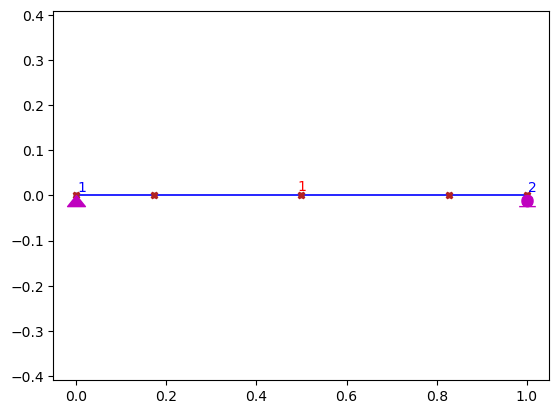

In [64]:

opsv.plot_model()

0.0999999999999999

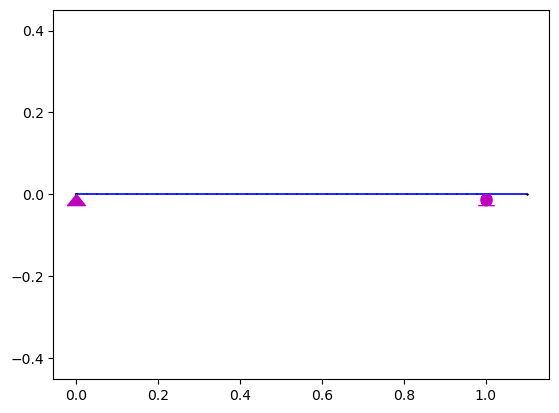

In [65]:
opsv.plot_defo()

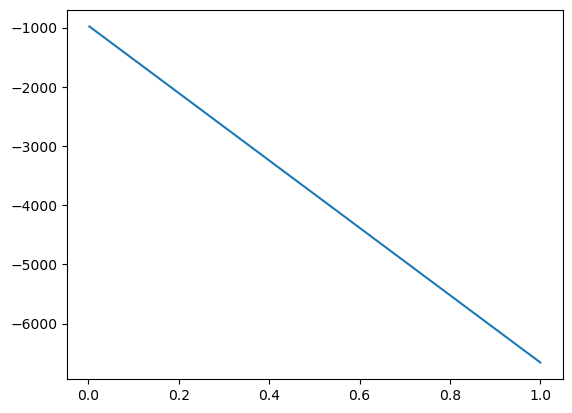

In [66]:

from contextlib import ExitStack

filenames = ["node_disp.out", "reaction.out"]

with ExitStack() as stack:
    files = [stack.enter_context(open(fname, "r")) for fname in filenames]
    lines1 = files[0].readlines()
    lines2 = files[1].readlines()
    strains = np.array([float(line.split()[1]) for line in lines1[1:]])
    reactions = np.array([float(line.split()[1]) for line in lines2[1:]])
    
plt.plot(strains, reactions)

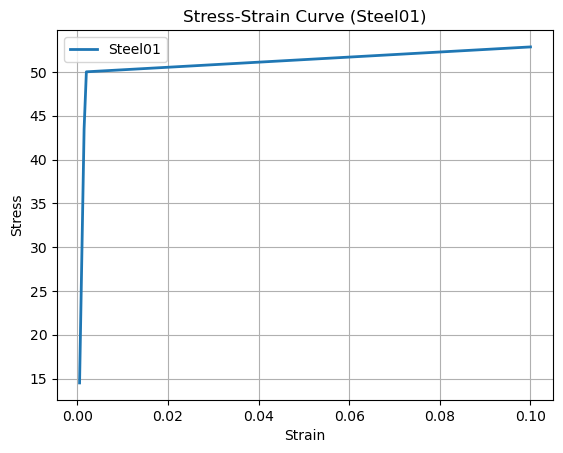

In [74]:
import openseespy.opensees as ops
import matplotlib.pyplot as plt

# -------------------------------
# Model Initialization
# -------------------------------
ops.wipe()
ops.model('basic', '-ndm', 1, '-ndf', 1)

# -------------------------------
# Geometry & Material
# -------------------------------
L = 1.0  # length of bar
A = 1.0  # area of bar

# Nodes
ops.node(1, 0.0)
ops.node(2, L)

# Fix left end
ops.fix(1, 1)

# Define material: Steel01(tag, Fy, E0, b)
Fy = 50.0           # ksi
E0 = 29000.0        # ksi (realistic steel)
b = 0.001            # strain hardening ratio
ops.uniaxialMaterial('Steel01', 1, Fy, E0, b)

# Define element
ops.element('truss', 1, 1, 2, A, 1)

# -------------------------------
# Load & Analysis Setup
# -------------------------------
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)
ops.load(2, 1e-8)  # Dummy load to satisfy pattern requirements

# Analysis parameters
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-8, 10)
ops.algorithm('Newton')

# Set displacement control
max_disp = 0.1      # 10% strain
n_steps = 200
disp_inc = max_disp / n_steps
ops.integrator('DisplacementControl', 2, 1, disp_inc)
ops.analysis('Static')

# -------------------------------
# Analysis Execution
# -------------------------------
disp_vals = []
strain_vals = []
stress_vals = []

for step in range(n_steps):
    ok = ops.analyze(1)
    if ok != 0:
        print(f"Analysis failed at step {step}")
        break

    disp = ops.nodeDisp(2, 1)
    strain = disp / L
    force = ops.eleResponse(1, 'axialForce')[0]  # Extract scalar from list
    stress = force / A
    disp_vals.append(disp)
    strain_vals.append(strain)
    stress_vals.append(stress)

# -------------------------------
# Plot Stress-Strain Curve
# -------------------------------
plt.plot(strain_vals, stress_vals, label="Steel01", linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress")
plt.title("Stress-Strain Curve (Steel01)")
plt.grid(True)
plt.legend()
plt.show()


In [3]:
a= [100, 200, 300]
b= [400, 500, 600]
for i, z in enumerate(zip(a, b)):
    print(i, z[0], z[1])

0 100 400
1 200 500
2 300 600


In [87]:
import openseespy.opensees as ops
import numpy as np


# Reset model
ops.wipe()
ops.model('basic', '-ndm', 1, '-ndf', 1)


# Materials
nMat = 2
matTags = list(range(1, nMat + 1))

Fy, E0, b = 50, 29000, 0.005
ops.uniaxialMaterial('Steel01', matTags[0], Fy, E0, b)

R0, cR1, cR2 = 15, 0.925, 0.15
ops.uniaxialMaterial('Steel02', matTags[1], Fy, E0, b, R0, cR1, cR2)


# Geometry
A, L = 1.0, 1.0  # Area and length
fixed_nodeTags = list(range(1, nMat + 1)) 
free_nodeTags = []
eleTags =  list(range(1, nMat + 1))
for i in range(nMat):
    free_nodeTags.append(fixed_nodeTags[i] + 100)
    ops.node(fixed_nodeTags[i], 0.0)
    ops.node(free_nodeTags[i], L)
    ops.fix(fixed_nodeTags[i], 1)
    if i != 0:
        ops.equalDOF(free_nodeTags[0], free_nodeTags[i], 1)
    ops.element('Truss', eleTags[i], fixed_nodeTags[i], free_nodeTags[i], A, matTags[i])  




# Cyclic strain history (OpenSees doc example)
# https://opensees.berkeley.edu/OpenSees/manuals/comparisonManual/2770.htm
run1 = [0.20]
run2 = [-0.20]
run3 = [0.02, -0.02, 0.0]
run4 = [-0.02, 0.02, 0.0]
run5 = [0.20, -0.20, 0.0]
run6 = [-0.20, 0.20, 0.0]
run7 = [0.0005, 0, 0.001, 0, 0.005, 0, 0.05, 0, 0.10, 0, 0.15, 0, 0.20, 0.0]
run8 = [-0.0005, 0, -0.001, 0, -0.005, 0, -0.05, 0, -0.10, 0, -0.15, 0, -0.20, 0.0]
run9 = [0.001, -0.001, 0.005, -0.005, 0.01, -0.01, 0.02, -0.02, 0.0]
run10 = [0.001, -0.001, 0.005, -0.005, 0.01, -0.01, 0.02, -0.02, 0.05, -0.05, 0.10, -0.10, 0.15, -0.15, 0.20, -0.20, 0.0]
runs = [run1, run2, run3, run4, run5, run6, run7, run8, run9, run10]


# Dummy load pattern
timeSeriesTag = 1
ops.timeSeries('Linear', timeSeriesTag)
patternTag = 1
ops.pattern('Plain', patternTag, timeSeriesTag)
loading_nodeTag = free_nodeTags[0]
load_value = 1e-8
ops.load(loading_nodeTag, load_value)  # Dummy load to satisfy pattern requirements


# Analysis settings
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1e-8, 10)
ops.algorithm('Newton')        
   
nIncr = 1000
dof = 1
strains = {}
stresses = {}


for i, run in enumerate(runs): # Loop over each strain history
    strain_peaks = run
    disp_peaks = [L * eps for eps in strain_peaks] 
    strains[i] = [0]  
    stresses[i] = {}
    for eleTag in eleTags:
        stresses[i][eleTag] = [0]   
    current_disp = 0.0   
    ops.reset() # Earase previous analysis results
            
    for target_disp in disp_peaks: # Loop over displacement peaks in each history
        delta_disp = (target_disp - current_disp) / nIncr

        for _ in range(nIncr): # Incremental analysis, run the analysis for each displacement increment
            ops.integrator('DisplacementControl', free_nodeTags[0], dof, delta_disp)
            ops.analysis('Static')
            ok = ops.analyze(1)
            
            if ok != 0:
                print(f"Analysis failed during increment to {target_disp}")
                break
            current_disp += delta_disp
            strains[i].append(current_disp / L)
            for eleTag in eleTags:
                stress = ops.eleResponse(eleTag, 'axialForce')[0] / A
                stresses[i][eleTag].append(stress)



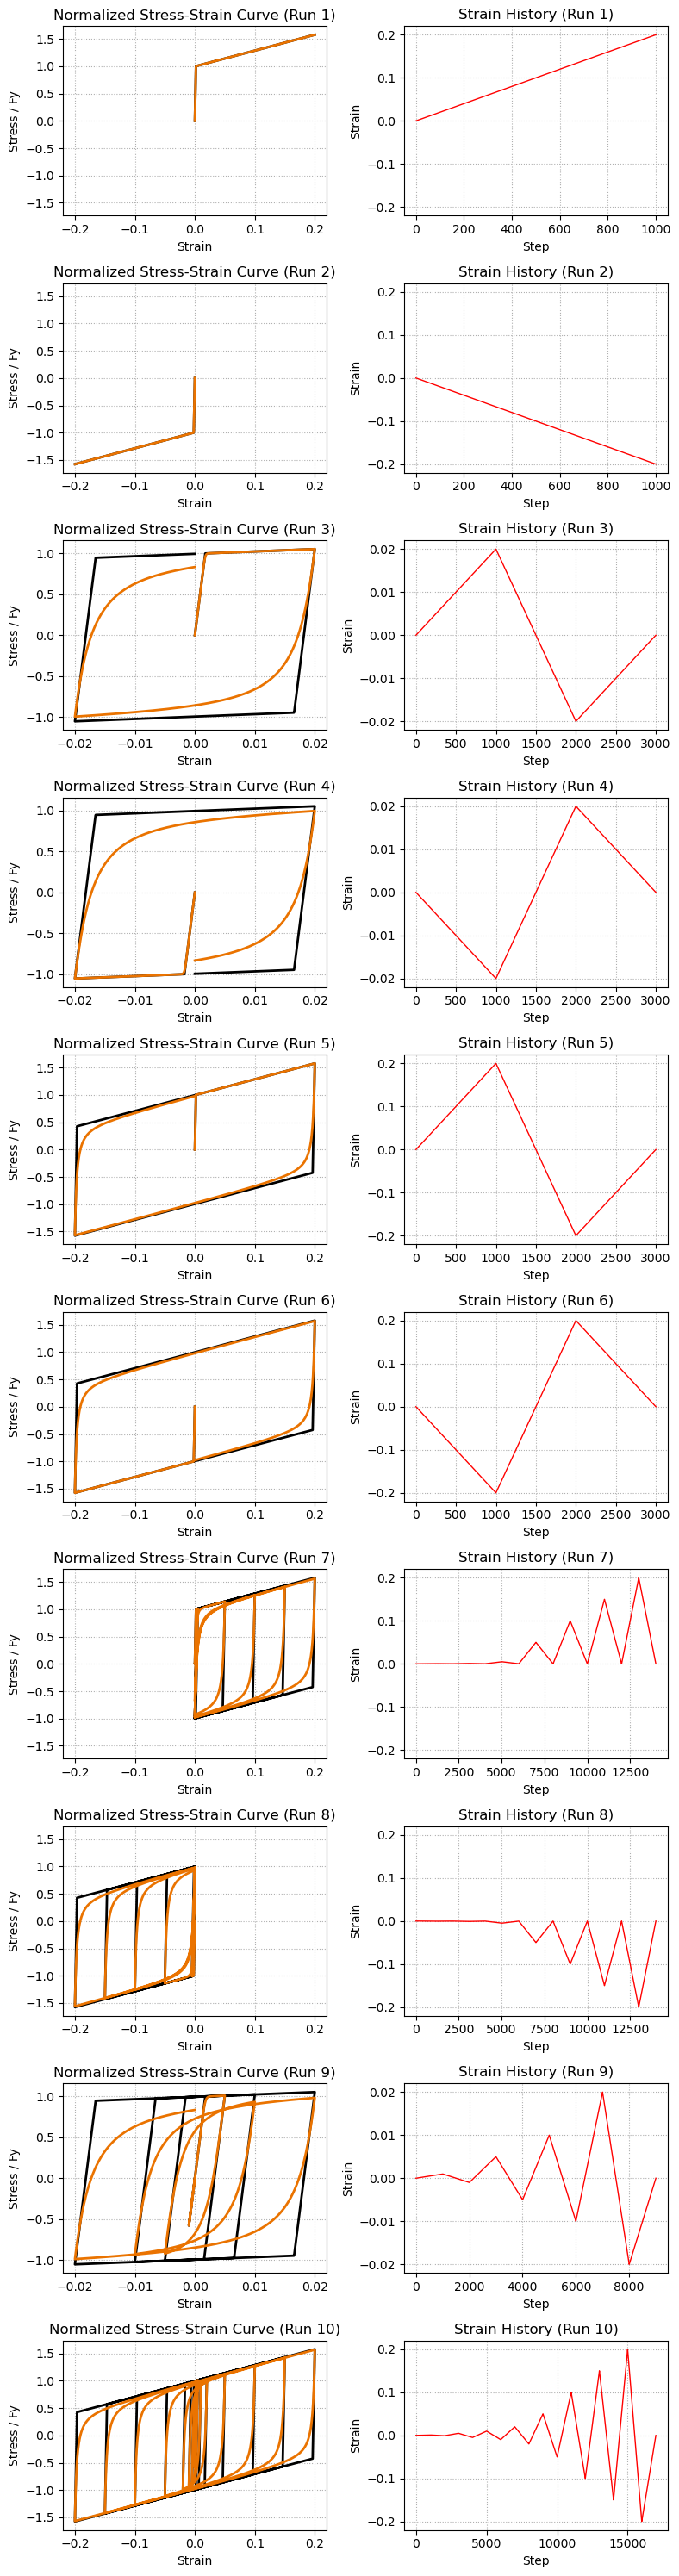

In [93]:
import matplotlib.pyplot as plt
import numpy as np


nRuns = len(runs)
colors = ['black', '#EA7300']
fig, axes = plt.subplots(nRuns, 2, figsize=(8, 30), width_ratios=[1,1])

for i in range(nRuns):
    strain = strains[i]
    max_strain = max(abs(np.array(strain)))
    
    axis = axes[i, 0]
    max_stress = 0
    for j, eleTag in enumerate(eleTags):
        stress = stresses[i][eleTag]
        norm_stress = np.array(stress) / Fy  # Normalize stress by yield strength    
        axis.plot(strain, norm_stress, color=colors[j], linewidth=2)
        max_stress = max(max_stress, np.max(np.abs(norm_stress)))
    axis.set_ylim(max_stress * np.array([-1.1, 1.1]))
    axis.set_xlim(max_strain * np.array([-1.1, 1.1]))
    axis.set_xlabel('Strain')
    axis.set_ylabel('Stress / Fy')
    axis.set_title(f'Normalized Stress-Strain Curve (Run {i+1})')
    axis.grid(True, linestyle=':')
        
    step = range(nIncr * len(runs[i])+1)
    axis = axes[i, 1]
    axis.plot(step, strain, color='red', linewidth=1, label=f'Run {i+1}')
    
    axis.set_ylim(max_strain * np.array([-1.1, 1.1]))
    axis.set_xlabel('Step')
    axis.set_ylabel('Strain')
    axis.set_title(f'Strain History (Run {i+1})')
    axis.grid(True, linestyle=':')
    
plt.tight_layout()
plt.show()